<b><font color="SteelBlue" size="+3">Segmentez des clients d'un site e-commerce</font></b>

# Introduction

Ce notebook la partie contrat de maintenance du projet pour OLIST.

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Brazil_Regions.png',
 'carte-bresil.jpg',
 'Carte_bresil.png',
 'data',
 'Deveau_Estelle_1_script_032024.sql',
 'Deveau_Estelle_2_notebook_exploration_032024.ipynb',
 'Deveau_Estelle_3_notebook_essais_032024.ipynb',
 'Deveau_Estelle_4_notebook_simulation_032024.ipynb',
 'svg']

In [3]:
os.listdir("data/sources/")

['Customer.csv',
 'CustomerCategoryCounts.csv',
 'CustomerPaymentPreferences.csv',
 'periodes',
 'Script-avec-periode.sql',
 'Script_projet.sql',
 'svg_scripts']

In [4]:
os.listdir("data/sources/periodes")

['Customer', 'Payment']

In [5]:
os.listdir("data/sources/periodes/Customer")

['Customer_170101_180101.csv',
 'Customer_170101_180115.csv',
 'Customer_170101_180201.csv',
 'Customer_170101_180215.csv',
 'Customer_170101_180301.csv',
 'Customer_170101_180315.csv',
 'Customer_170101_180401.csv',
 'Customer_170101_180415.csv',
 'Customer_170101_180501.csv',
 'Customer_170101_180515.csv',
 'Customer_170101_180601.csv',
 'Customer_170101_180615.csv',
 'Customer_170101_180701.csv',
 'Customer_170101_180715.csv',
 'Customer_170101_180801.csv']

In [6]:
os.listdir("data/sources/periodes/Payment")

['CustomerPaymentPreferences_170101_180101.csv',
 'CustomerPaymentPreferences_170101_180115.csv',
 'CustomerPaymentPreferences_170101_180201.csv',
 'CustomerPaymentPreferences_170101_180215.csv',
 'CustomerPaymentPreferences_170101_180301.csv',
 'CustomerPaymentPreferences_170101_180315.csv',
 'CustomerPaymentPreferences_170101_180401.csv',
 'CustomerPaymentPreferences_170101_180415.csv',
 'CustomerPaymentPreferences_170101_180501.csv',
 'CustomerPaymentPreferences_170101_180515.csv',
 'CustomerPaymentPreferences_170101_180601.csv',
 'CustomerPaymentPreferences_170101_180615.csv',
 'CustomerPaymentPreferences_170101_180701.csv',
 'CustomerPaymentPreferences_170101_180715.csv',
 'CustomerPaymentPreferences_170101_180801.csv']

# Liste des fichiers

In [7]:
pathCustomer = "./data/sources/periodes/Customer"
pathPayment = "./data/sources/periodes/Payment"

In [8]:
# Obtenir la liste des fichiers CSV dans chaque répertoire
data_customer = sorted([os.path.join(pathCustomer, f) for f in os.listdir(pathCustomer) if f.endswith('.csv')])
data_payment = sorted([os.path.join(pathPayment, f) for f in os.listdir(pathPayment) if f.endswith('.csv')])

In [9]:
assert len(data_customer) == len(data_payment), "Les répertoires doivent contenir le même nombre de fichiers CSV."

# Prétraitement des données

In [10]:
def merge(df_customer, df_payment):
    # Calculer la somme totale des paiements pour chaque client
    total_payment_by_customer = df_payment.groupby('customer_unique_id')['TotalPaymentValue'].sum()

    # Calculer la somme totale des échéances de paiement pour chaque client
    total_installments_by_customer = df_payment.groupby('customer_unique_id')['TotalInstallments'].sum()

    # Créer un DataFrame pour la somme totale des paiements et des échéances de paiement
    total_by_customer = pd.concat([total_payment_by_customer, total_installments_by_customer], axis=1).reset_index()

    # Pivot pour obtenir le pourcentage par type de paiement pour chaque client
    df_payment_pivot = df_payment.pivot_table(index='customer_unique_id', 
                                              columns='payment_type', 
                                              values='TotalPaymentValue', 
                                              aggfunc='sum',
                                              fill_value=0)

    # Calculer les pourcentages de paiement pour chaque type
    for col in df_payment_pivot.columns:
        col_pct_name = f'{col}_pct'
        df_payment_pivot[col_pct_name] = df_payment_pivot[col] / total_by_customer.set_index('customer_unique_id')['TotalPaymentValue'] * 100

    # Ajouter les données totales au DataFrame pivoté
    df_payment_pivot = df_payment_pivot.merge(total_by_customer, on='customer_unique_id')

    # Fusionner df_customer avec les colonnes sélectionnées de df_payment_pivot
    df_merged = pd.merge(df_customer,
                         df_payment_pivot[['customer_unique_id','boleto_pct','credit_card_pct','debit_card_pct','voucher_pct',
                                       'TotalPaymentValue','TotalInstallments']],
                         on='customer_unique_id',
                         how='left')

    return df_merged

In [11]:
def nettoyage(data):
    # Formats
    data['FirstOrderDate'] = pd.to_datetime(data['FirstOrderDate'])
    data['LastOrderDate'] = pd.to_datetime(data['LastOrderDate'])

    # doublons
    data = data.drop_duplicates(subset=["customer_unique_id"])
    data = data.drop_duplicates(subset=['FirstOrderDate','TotalSpent','customer_city'])

    #print(f'Taille du dataframe après le nettoyage : {data.shape}')

    return data


In [12]:
def verification(data):
    tolerance = 0.1
    data = data.copy()

    # Vérifier que la somme des pourcentages des sommes dépensées dans chaque catégorie est proche de 100%
    data = data[(abs(data['boleto_pct'] + data['credit_card_pct'] + data['debit_card_pct'] + data['voucher_pct'] - 100) <= tolerance)]
      
    # Vérifier la cohérence entre la valeur totale des paiements et la somme de TotalSpent + TotalFreight
    data['payment_difference'] = abs(data['TotalPaymentValue'] - (data['TotalSpent'] + data['TotalFreight']))
    data = data[data['payment_difference'] <= data['TotalPaymentValue'] * tolerance]
    
    # Supprimer les lignes où 'AverageReviewScore' n'est pas compris entre 0 et 5
    data = data.query("AverageReviewScore.isna() or (AverageReviewScore >= 0 and AverageReviewScore <= 5)")
    
    # Supprimer les lignes où 'NumberOfComments' ou 'NumberOfCommentTitles' est supérieur à 'NumberOfReviews'
    data = data.query("NumberOfComments <= NumberOfReviews and NumberOfCommentTitles <= NumberOfReviews")
    
    # Remplacer les valeurs de 'DifferentCategories' égales à 0 par 1
    data.loc[data['DifferentCategories'] == 0, 'DifferentCategories'] = 1

    # Suppression des colonnes qui ne servaient qu'à la verification des données
    data = data.drop(columns=['TotalPaymentValue'])

    #print(f'Taille du dataframe après la vérification : {data.shape}')

    return data

In [13]:
def completion(data):
    # Supprimer les lignes où la colonne 'AvgWeight' est NaN
    data = data.dropna(subset=['AvgWeight'])
    #data['AvgWeight'] = data['AvgWeight'].fillna(0)

    #print(f'Taille du dataframe après la complétion : {data.shape}')

    return data

In [14]:
def featuring(df, featureslist):
    #print(df.columns.tolist())
    df = df.copy()
    
    # Recence
    reference_date = df['LastOrderDate'].max()
    df['Recency'] = (reference_date - df['LastOrderDate']).dt.days

    # Frequence
    df['Frequency'] = df['TotalOrders']

    # Montant (= panier moyen)
    df['TotalAmount'] = df['TotalSpent'] + df['TotalFreight']
    df['AvgBasket'] = df['TotalAmount']/df['TotalOrders']

    # Calcul de l'indice d'engagement en fonction des commentaires
    df['EngagementIndex'] = (0.5 * df['NumberOfReviews'] + 0.25 * df['NumberOfCommentTitles'] + 0.25 * df['NumberOfComments']
                            ) / (df['nb_item'])

    df = df[['customer_unique_id'] + featureslist]
    
    #print(f'Taille du dataframe après le feature engineering : {df.shape}')

    return df

In [15]:
standard_scaler = StandardScaler()

def scale(data):
    # Définir 'customer_unique_id' comme l'index du DataFrame
    data = data.set_index('customer_unique_id')
    
    scaled_data = pd.DataFrame(standard_scaler.fit_transform(data), index=data.index, columns=data.columns)
    
    return scaled_data

In [16]:
def traitement(file_cutomer, file_payment, featureslist):
    df_merged = merge(file_cutomer, file_payment)
    df_cleaned = nettoyage(df_merged)
    df_verified = verification(df_cleaned)
    df_completed = completion(df_verified)
    df_featured = featuring(df_completed, featureslist)
    df_scaled = scale(df_featured)
    
    #print(f'Taille du dataframe après le traitement des données : {df_featured.shape}')

    return df_scaled

# ARI

In [17]:
# Calcul ARI
def ari_calc(customer_files, payment_files, featurelist):

    ari_scores = []

    
    # Initialiser KMeans une seule fois avec le nombre de clusters déterminé
    kmeans = KMeans(n_clusters=9, random_state=42,n_init=10)
    customer_labels_first_period = {} 

    
    for i, (file_customer, file_payment) in enumerate(zip(customer_files, payment_files)):
        # Charger les fichiers CSV
        df_customer = pd.read_csv(file_customer)
        df_payment = pd.read_csv(file_payment)
        
        # Prétraitement
        data = traitement(df_customer, df_payment, features)    

        if i == 0 :
            # Entraîner KMeans sur la première période
            kmeans.fit(data[featurelist])
            # identifiant des client p1
            customer_ids_first_period = set(data.index)  
            # Stockage des labels de la première période
            customer_labels_first_period = {idx: lbl for idx, lbl in zip(data.index, kmeans.labels_)}
            ari_scores.append(1.0)
        else:
            # Filtrer pour ne garder que les clients présents lors de la première période
            data_common = data.loc[data.index.isin(customer_ids_first_period)].copy()
            # prediction si reentrainement
            predicted_clusters = kmeans.predict(data_common[featurelist])
            # Filtrer labels_de_reference pour ne garder que ceux correspondant aux clients communs
            labels_de_reference = [customer_labels_first_period[idx] for idx in data_common.index if idx in customer_labels_first_period]
            # Calcul de l'ARI
            ari = adjusted_rand_score(labels_de_reference, predicted_clusters)
            ari_scores.append(ari)
    
    return ari_scores

In [18]:
# liste des features
features = [ 'Recency', 'Frequency', 'AvgBasket', 'nb_item', 'AverageReviewScore', 'EngagementIndex', 'ActualDeliveryTime', 
               'EstimatedActualDifference', 'AvgWeight', 'TotalInstallments', 'boleto_pct', 'voucher_pct']

In [19]:
ari_scores =  ari_calc(data_customer, data_payment, features)
ari_scores

[1.0,
 0.9436108655680427,
 0.8770572623185264,
 0.8332862056194202,
 0.7808504691054889,
 0.734386750079927,
 0.6880605586465735,
 0.6563938701946584,
 0.6270099642173933,
 0.5995686630358056,
 0.5806689319435129,
 0.566706925733659,
 0.5540956749283781,
 0.545966732953086,
 0.534522581417026]

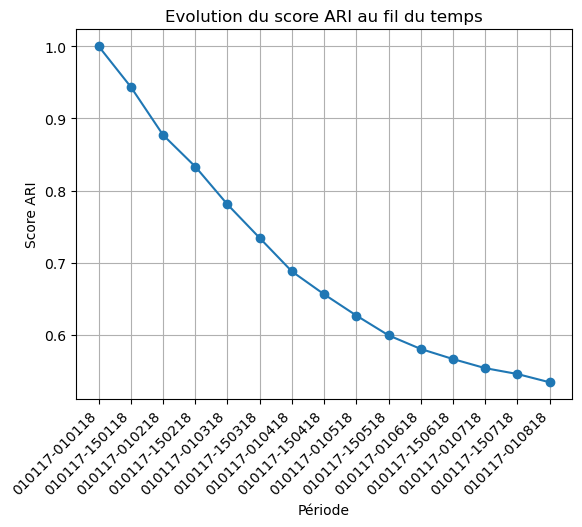

In [20]:
# Affichage de la courbe ARI
plt.plot(ari_scores, marker='o', linestyle='-')
plt.title('Evolution du score ARI au fil du temps')
plt.xlabel('Période')
plt.ylabel('Score ARI')
plt.xticks(range(len(ari_scores)), ['010117-010118', '010117-150118', '010117-010218', '010117-150218',
                                    '010117-010318', '010117-150318', '010117-010418', '010117-150418',
                                    '010117-010518', '010117-150518', '010117-010618', '010117-150618',
                                    '010117-010718', '010117-150718', '010117-010818'], rotation=45, ha='right') 
plt.grid(True)
plt.show()

# Test de Komogorov-Smirnov

In [21]:
def ks_analysis_between_periods(file_customer_previous, file_payment_previous, file_customer_current, file_payment_current, features):
    # Charger les données pour les deux périodes
    df_customer_previous = pd.read_csv(file_customer_previous)
    df_payment_previous = pd.read_csv(file_payment_previous)
    data_previous = traitement(df_customer_previous, df_payment_previous, features)
    
    df_customer_current = pd.read_csv(file_customer_current)
    df_payment_current = pd.read_csv(file_payment_current)
    data_current = traitement(df_customer_current, df_payment_current, features)
    
    # Initialiser un dictionnaire pour stocker les résultats du test KS
    ks_results = {}
    
    # Exécuter le test KS pour chaque feature
    for feature in features:
        sample1 = data_previous[feature].dropna()
        sample2 = data_current[feature].dropna()
        ks_statistic, p_value = ks_2samp(sample1, sample2)
        ks_results[feature] = {'ks_statistic': ks_statistic, 'p_value': p_value}
    
    return ks_results


In [23]:
ks_results_all_periods = []

for i in range(len(data_customer) - 1):
    ks_results = ks_analysis_between_periods(data_customer[i], data_payment[i], data_customer[i+1], data_payment[i+1], features)
    ks_results_all_periods.append(ks_results)


In [29]:
ks_results_all_periods

[{'Recency': {'ks_statistic': 0.05969163418892495,
   'p_value': 2.8419149615857447e-67},
  'Frequency': {'ks_statistic': 0.9709540585232583, 'p_value': 0.0},
  'AvgBasket': {'ks_statistic': 0.010139130730985116,
   'p_value': 0.023518113124350218},
  'nb_item': {'ks_statistic': 0.8771778464782994, 'p_value': 0.0},
  'AverageReviewScore': {'ks_statistic': 0.5860710768955331, 'p_value': 0.0},
  'EngagementIndex': {'ks_statistic': 0.5336787386917007, 'p_value': 0.0},
  'ActualDeliveryTime': {'ks_statistic': 0.0033156524309383983,
   'p_value': 0.9710121316236291},
  'EstimatedActualDifference': {'ks_statistic': 0.014783639749225919,
   'p_value': 0.0001586776133994853},
  'AvgWeight': {'ks_statistic': 0.06298989938944739,
   'p_value': 7.186109341874668e-75},
  'TotalInstallments': {'ks_statistic': 0.4324298415893786, 'p_value': 0.0},
  'boleto_pct': {'ks_statistic': 0.7871945215289589, 'p_value': 0.0},
  'voucher_pct': {'ks_statistic': 0.9570062549428427, 'p_value': 0.0}},
 {'Recency': 

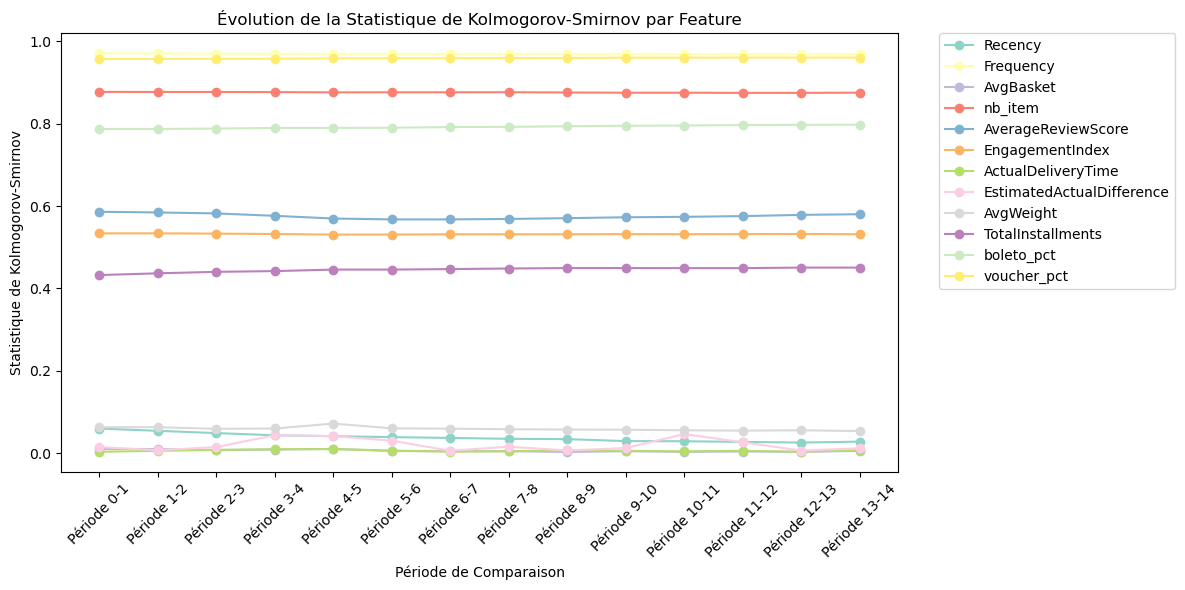

In [34]:
# Initialiser la figure
plt.figure(figsize=(12, 6))

# Nombre de périodes à comparer (nombre de tests KS réalisés)
n_periods = len(ks_results_all_periods)

palette = sns.color_palette('Set3', n_colors=len(features))

# Pour chaque feature, tracer les statistiques KS
for i, feature in enumerate(features):
    ks_statistics = [result[feature]['ks_statistic'] for result in ks_results_all_periods]
    plt.plot(range(n_periods), ks_statistics, marker='o', linestyle='-', label=feature, color=palette[i])

plt.xticks(range(n_periods), [f'Période {i}-{i+1}' for i in range(n_periods)], rotation=45)
plt.xlabel('Période de Comparaison')
plt.ylabel('Statistique de Kolmogorov-Smirnov')
plt.title('Évolution de la Statistique de Kolmogorov-Smirnov par Feature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# Graphiques

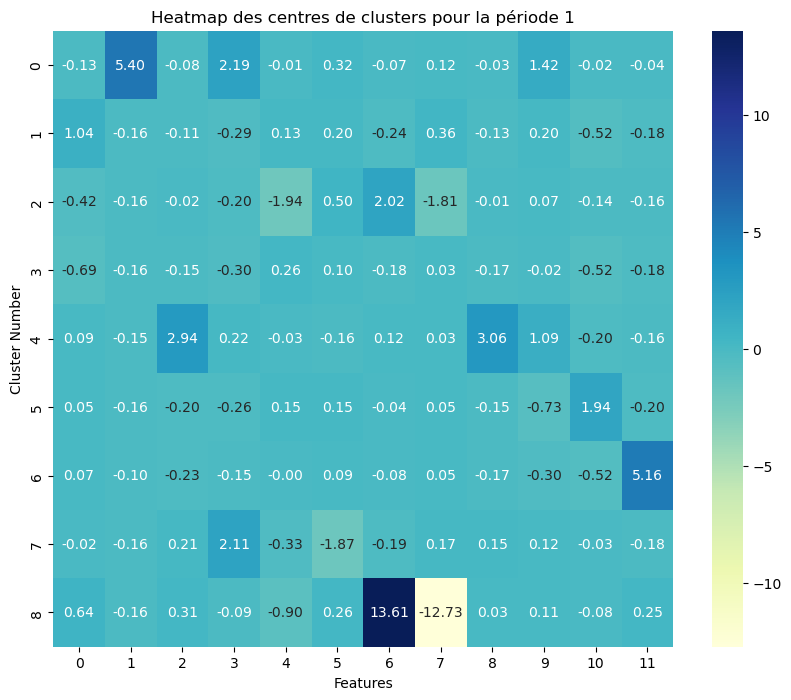

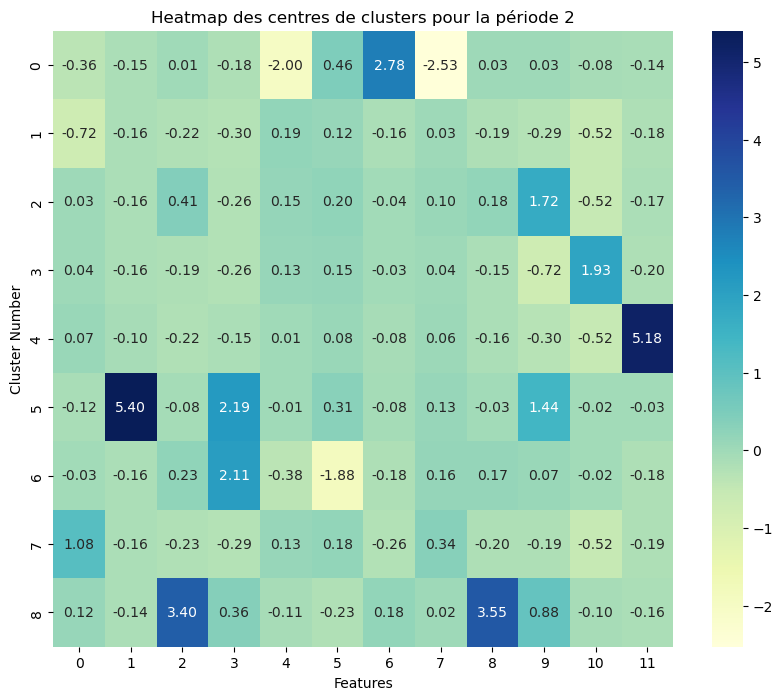

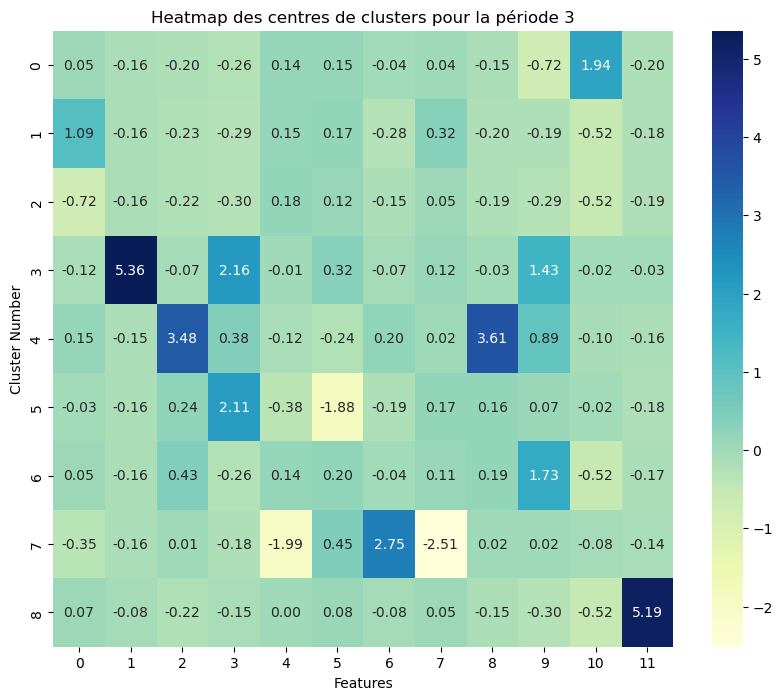

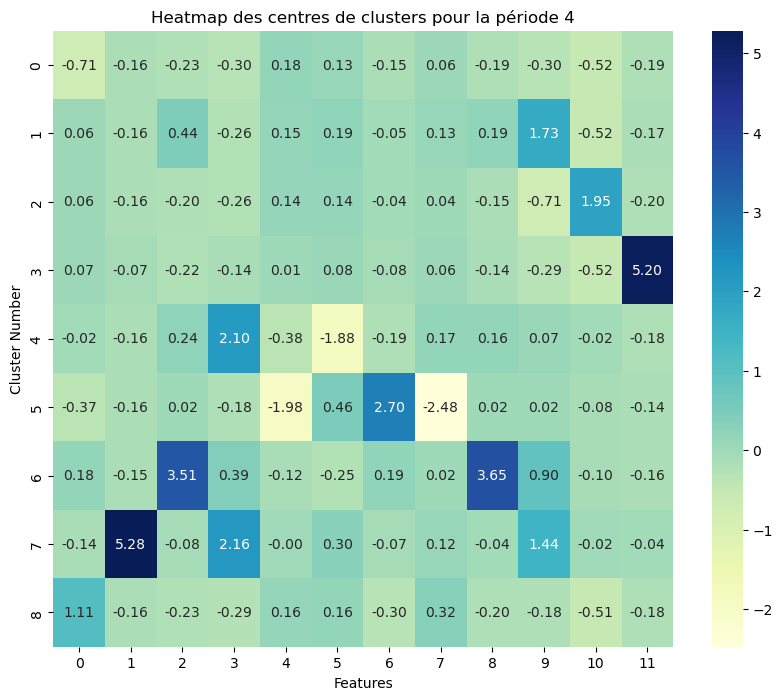

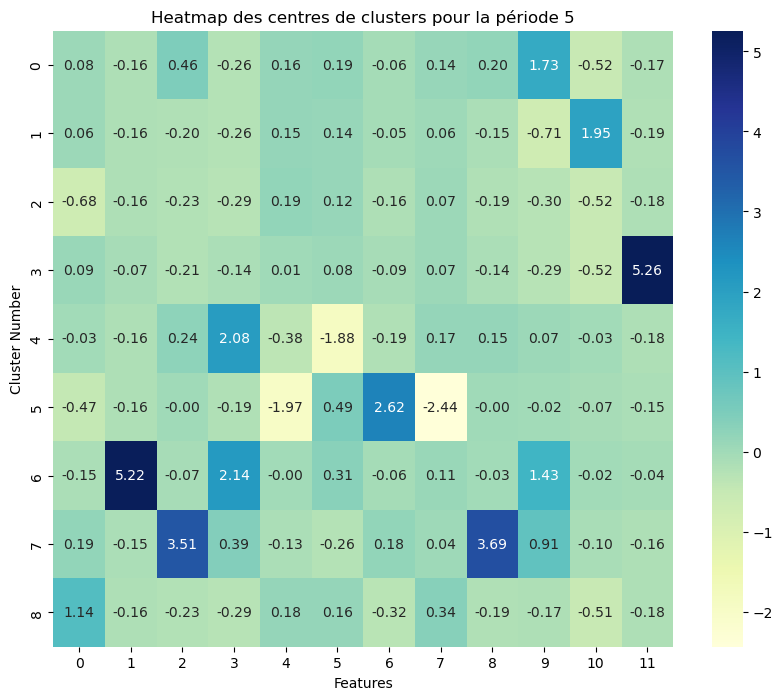

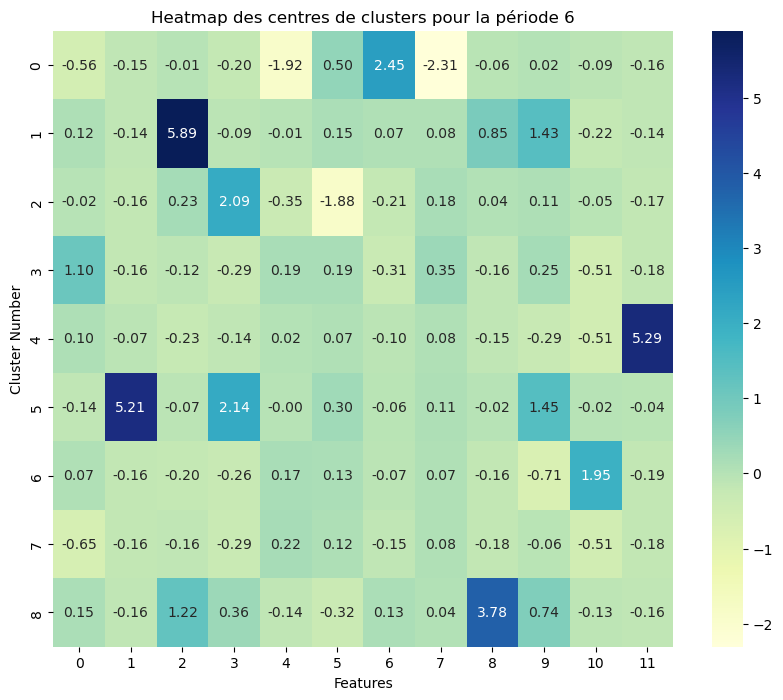

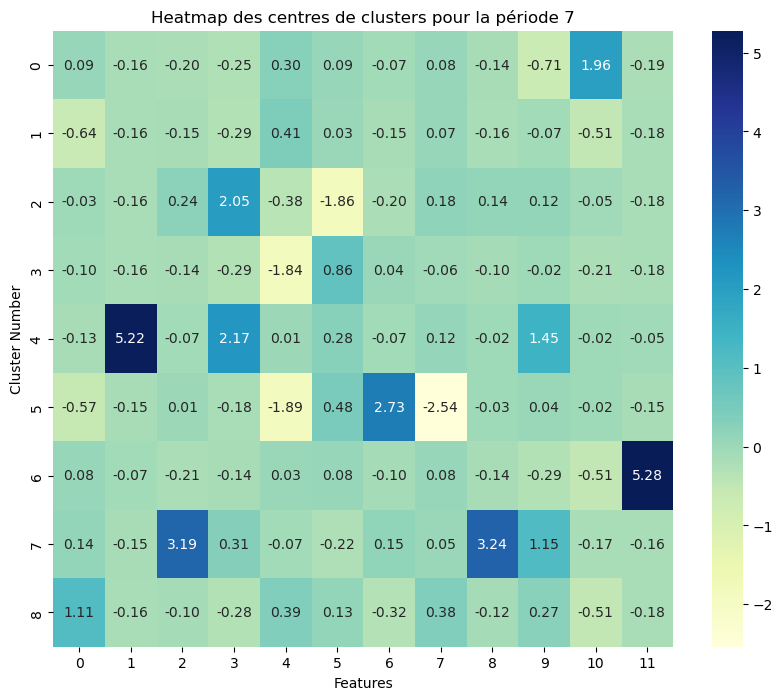

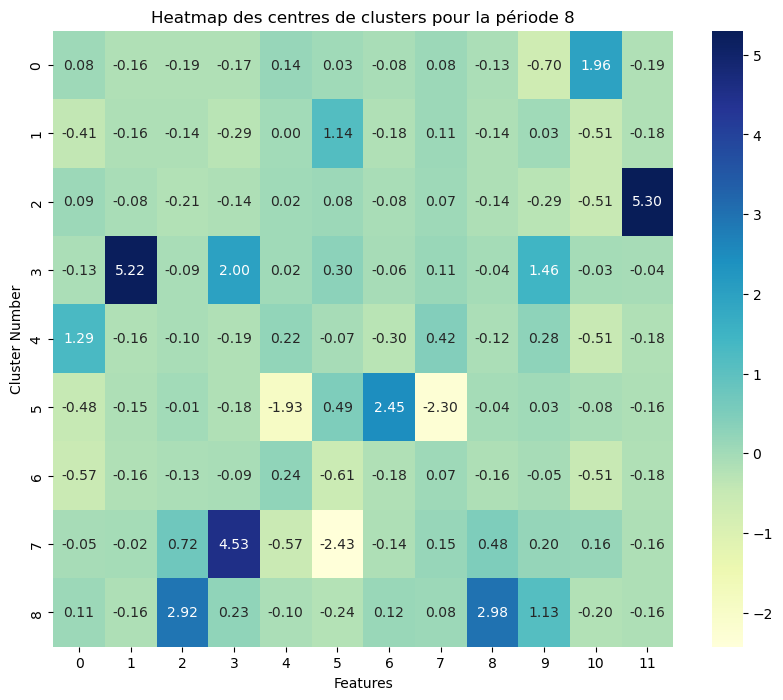

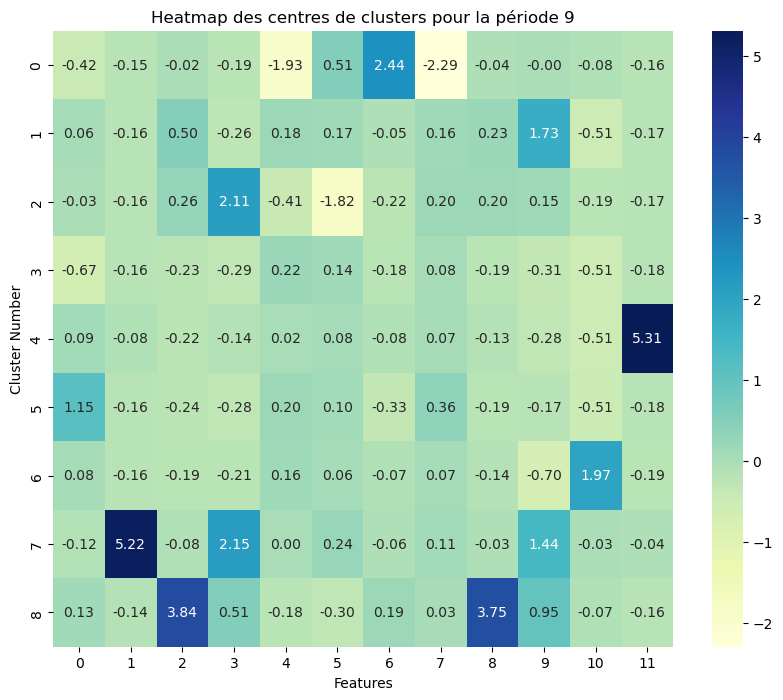

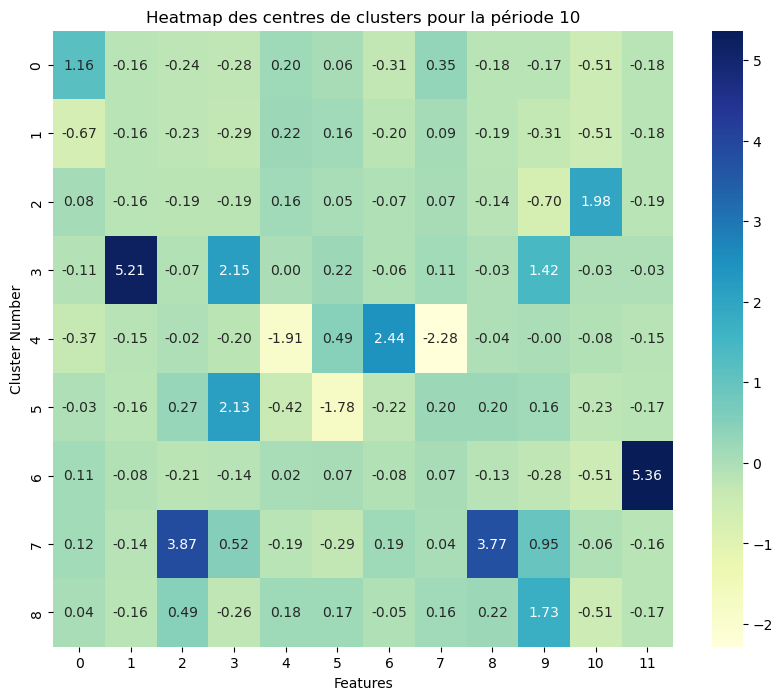

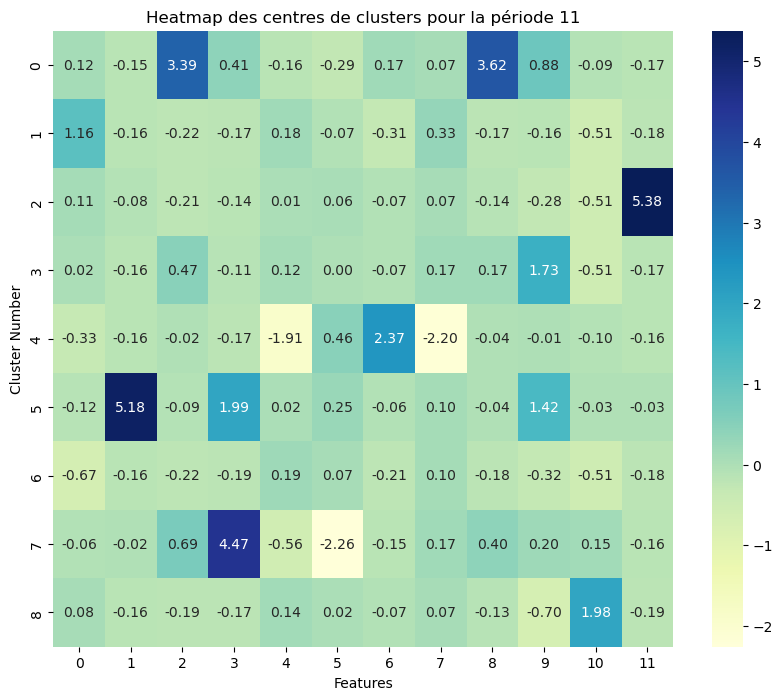

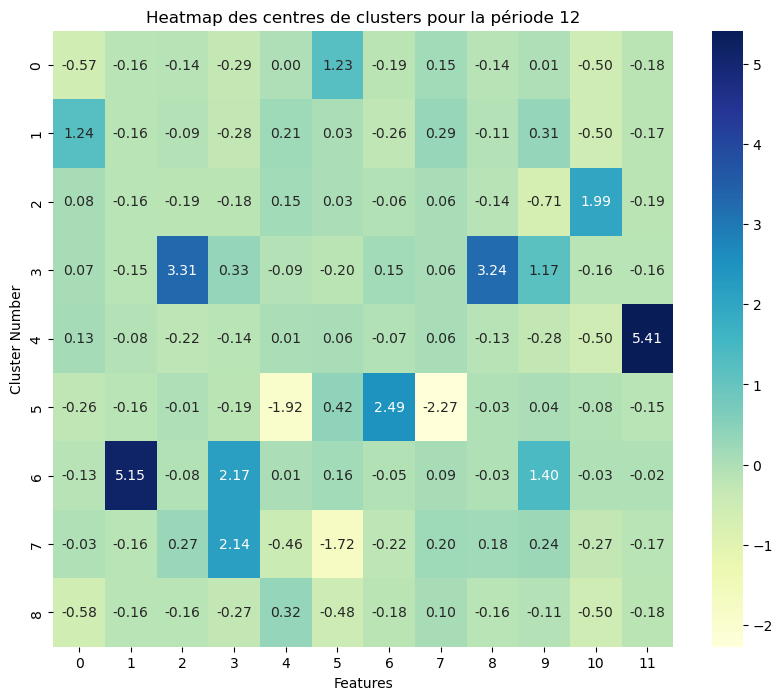

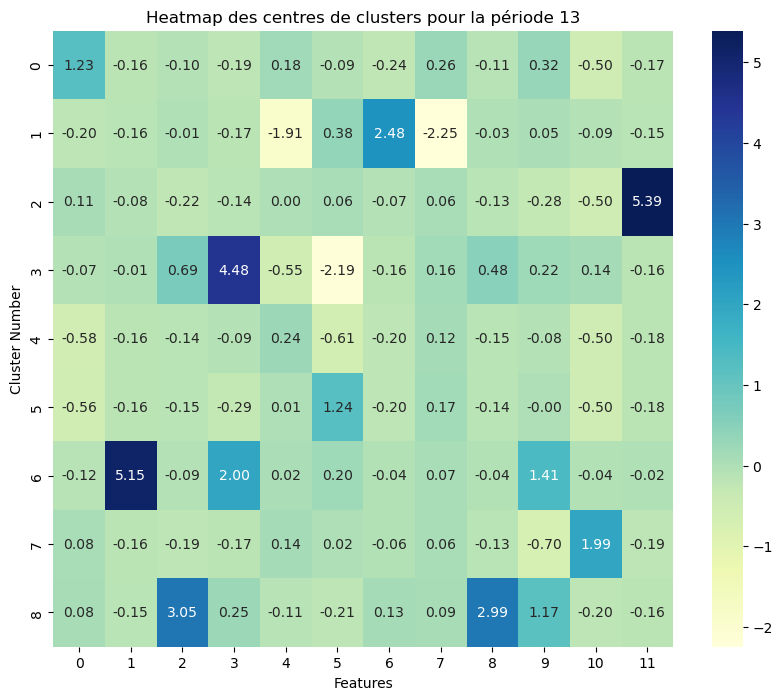

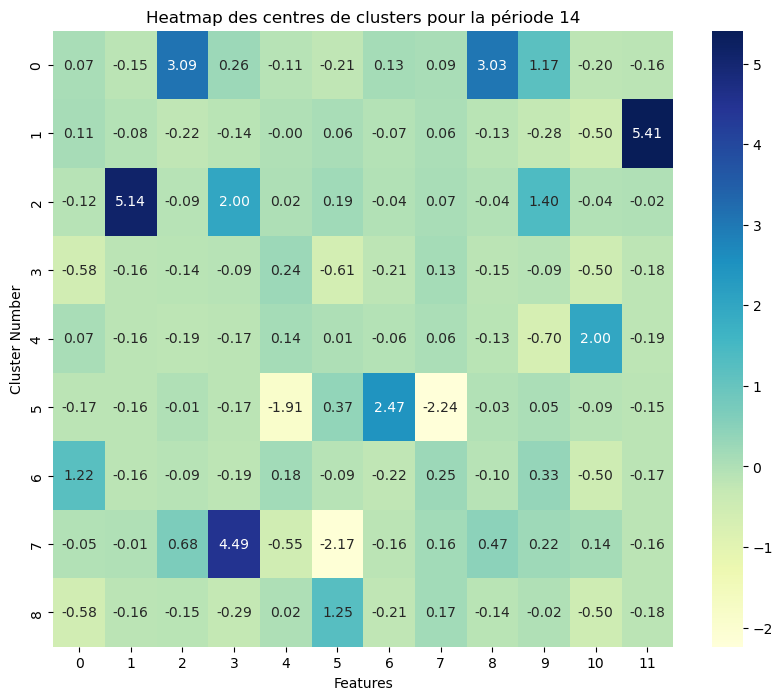

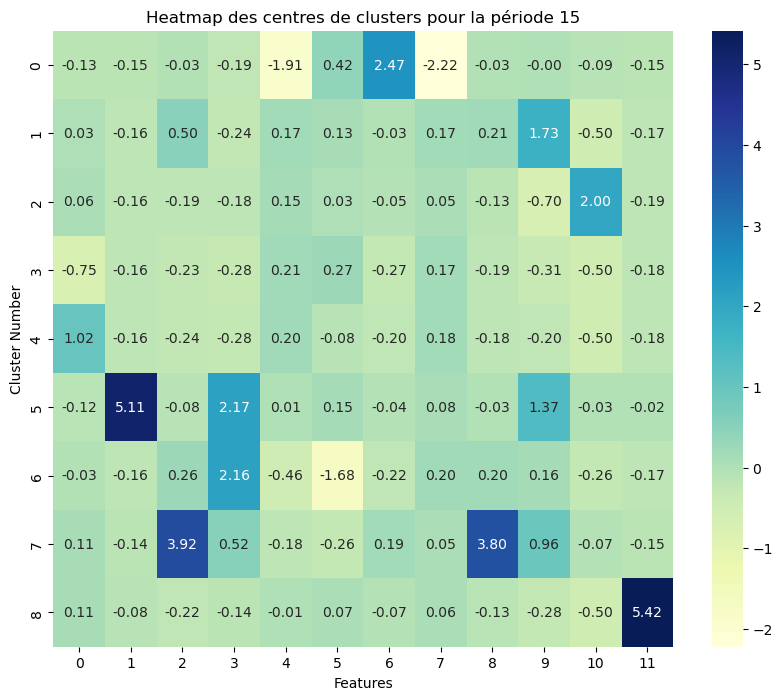

In [48]:
# Préparez une liste pour collecter les centres de clusters pour toutes les périodes
cluster_centers_all_periods = []

# Boucle sur les paires de fichiers pour chaque période
for i, (file_customer, file_payment) in enumerate(zip(data_customer, data_payment)):
    # Charger les fichiers CSV
    df_customer = pd.read_csv(file_customer)
    df_payment = pd.read_csv(file_payment)
    
    # Prétraitement
    data = traitement(df_customer, df_payment, features) 
    
    # Clustering avec KMeans
    kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
    kmeans.fit(data[features])
    
    # Stocker les centres des clusters
    cluster_centers_all_periods.append(kmeans.cluster_centers_)

# Affichage des heatmaps des centres de clusters pour chaque période
for idx, centers in enumerate(cluster_centers_all_periods):
    plt.figure(figsize=(10, 8))
    sns.heatmap(centers, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f'Heatmap des centres de clusters pour la période {idx+1}')
    plt.xlabel('Features')
    plt.ylabel('Cluster Number')
    plt.show()


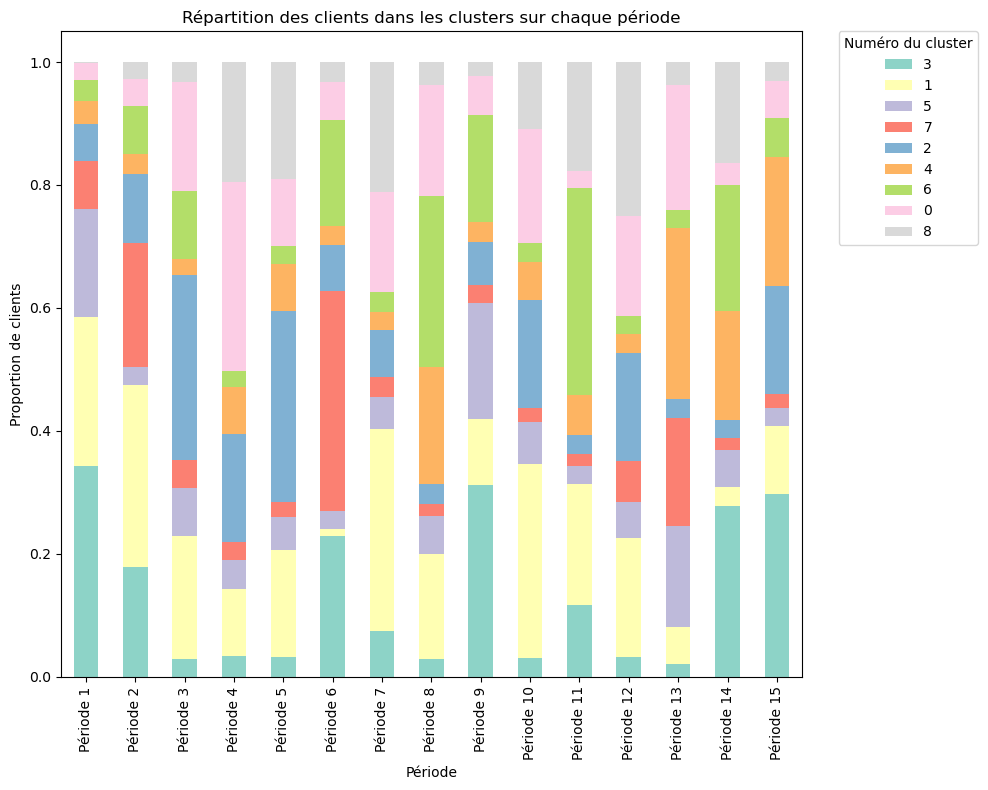

In [47]:
# Préparez une liste pour collecter les comptages de clusters pour toutes les périodes
cluster_counts_all_periods = []

# Boucle sur les paires de fichiers pour chaque période
for i, (file_customer, file_payment) in enumerate(zip(data_customer, data_payment)):
    # Charger les fichiers CSV
    df_customer = pd.read_csv(file_customer)
    df_payment = pd.read_csv(file_payment)
    
    # Prétraitement
    data = traitement(df_customer, df_payment, features) 

    # Clustering avec KMeans
    kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data[features])

    # Compter les occurrences de chaque label (cluster)
    counts = pd.Series(labels).value_counts(normalize=True)  
    cluster_counts_all_periods.append(counts)

df_cluster_counts = pd.DataFrame(cluster_counts_all_periods, index=[f'Période {i+1}' for i in range(len(cluster_counts_all_periods))])

palette = sns.color_palette('Set3', n_colors=df_cluster_counts.shape[1])

# Affichage des graphiques en barres empilées
df_cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 8), color=palette)
plt.title('Répartition des clients dans les clusters sur chaque période')
plt.xlabel('Période')
plt.ylabel('Proportion de clients')
plt.legend(title='Numéro du cluster',bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()  
plt.show()
